In [1]:
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import load_model
from sklearn.metrics import r2_score
import pmdarima as pm
from sklearn.svm import SVR
from tensorflow.keras import backend as K

import matplotlib.pyplot as plt
from matplotlib import pyplot
%matplotlib inline

#setting figure size
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 20,10

import tensorflow as tf
print('Configurando TF')
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True
session = tf.compat.v1.Session(config=config)

look_back = 100
forward_days = 30
num_periods = 20

Configurando TF


In [2]:
#Get the data and splits in input X and output Y, by spliting in `n` past days as input X 
#and `m` coming days as Y.
def processData(data, look_back, forward_days,jump=1,  scale=True):
    X,Y = [],[]
    for i in range(0,len(data) -look_back -forward_days +1, jump):
        d = data[i:i+look_back+forward_days]
        if scale == True:
            d = MinMaxScaler().fit_transform( d )
        X.append(d[:look_back])
        Y.append(d[look_back:look_back+forward_days])
    return np.array(X),np.array(Y)
    
#from keras import backend as K
def forecast_accuracy(forecast, actual):
    mape = np.mean(np.abs(forecast - actual)/np.abs(actual))  # MAPE
    me = np.mean(forecast - actual)             # ME
    mae = np.mean(np.abs(forecast - actual))    # MAE
    mpe = np.mean((forecast - actual)/actual)   # MPE
    rmse = np.mean((forecast - actual)**2)**.5  # RMSE
    #corr = np.corrcoef(forecast, actual)[0,1]   # corr
    mins = np.amin(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    maxs = np.amax(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    minmax = 1 - np.mean(mins/maxs)             # minmax
    #acf1 = acf(fc-test)[1]                      # ACF1
    R2 = r2_score(actual, forecast)
    #SS_res =  np.sum(np.square( actual-forecast ))
    #SS_tot = np.sum(np.square( actual - np.mean(actual) ) )
    #R2 = 1 - (SS_res/SS_tot) 
    
    #SS_res =  K.sum(K.square( actual-forecast ))
    #SS_tot = K.sum(K.square( actual - K.mean(actual) ) )
    #R2 = 1 - SS_res/(SS_tot + K.epsilon()) 
    return({'mape':mape, 'me':me, 'mae': mae, 
            'mpe': mpe, 'rmse':rmse, #'acf1':acf1, 
            'minmax':minmax, 'r2': R2})

# Cargar modelo entrenado solo con AAPL

In [3]:
model = load_model("model_apple.h5")

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


# Entrenar un modelo SVR

In [4]:
df_train = pd.read_feather("/home/benayas/datasets/lstm/train/train.feather")
appl = df_train[df_train['SYMBOL']=='AAPL']
array = appl['ADJ_CLOSE'].values.reshape(appl.shape[0],1)

In [5]:
# Normalize data and compile model

X,y = processData(array,look_back,forward_days)
y = np.array([list(a.ravel()) for a in y])
X_train, X_validate, y_train, y_validate = train_test_split(X, y, test_size=0.10, random_state=42)

In [6]:
# Train SVR
svr = SVR(kernel='rbf', C=100)
svr = svr.fit(X.reshape(X.shape[0], X.shape[1]), np.array([a[0] for a in y]))

# Cargar Dataset de Test

In [7]:
# Cargar datos test
df_test = pd.read_feather("/home/benayas/datasets/lstm/test/test.feather")
appl_test = df_test[df_test['SYMBOL']=='AAPL']
array_test = appl_test['ADJ_CLOSE'].values.reshape(appl_test.shape[0],1)

X_test,y_test = processData(array_test,look_back,forward_days, jump=num_periods, scale=False)

In [8]:
print('X shape {0}'.format(X_test.shape))
print('Y shape {0}'.format(y_test.shape))

X shape (22, 100, 1)
Y shape (22, 30, 1)


# Test con modelo LSTM entrenado en 1 valor (AAPL)

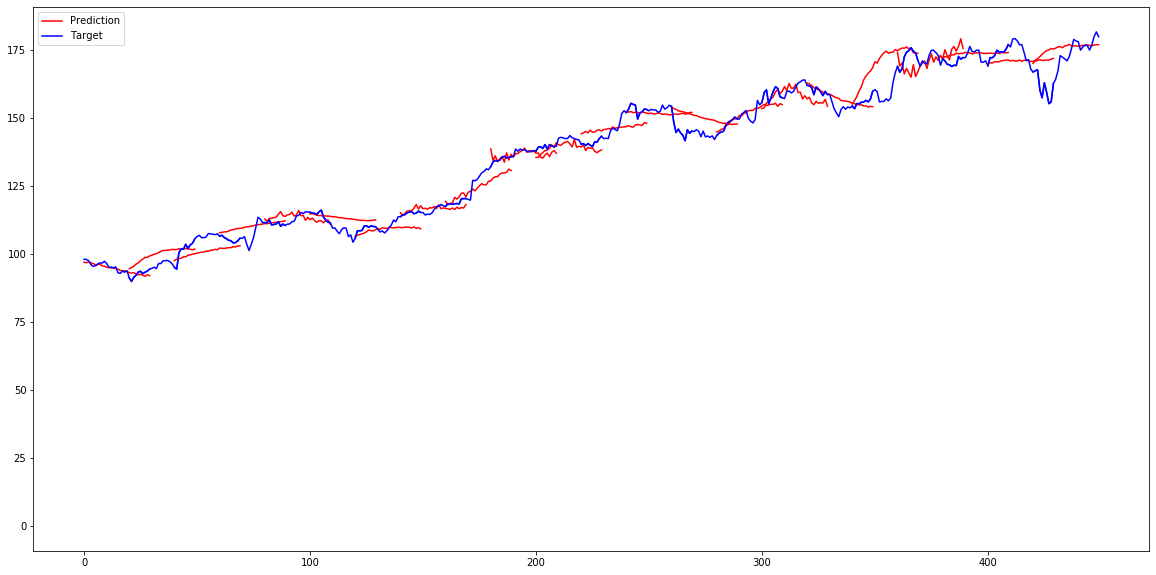

In [9]:
plt.figure(figsize = (20,10))

results = []

for i in range(0,len(X_test)):
    scl = MinMaxScaler()
    scl.fit(X_test[i])
    scl.fit(y_test[i])
    d = scl.transform( X_test[i] )
    y_pred = model.predict( d.reshape(1,d.shape[0],1) )
    y_pred = y_pred.reshape(-1,1)
    y_pred = scl.inverse_transform(y_pred.reshape(-1,1))
    
    results.append(forecast_accuracy(y_pred, y_test[i]))
    
    #plt.plot([x + i*forward_days for x in range(len(Xt[i]))], scl.inverse_transform(Xt[i].reshape(-1,1)), color='r')
    plt.plot([x + i*num_periods for x in range(len(y_pred))], y_pred, color='r')
    plt.plot([x + i*num_periods for x in range(len(y_test[i]))], y_test[i], color='b')
    
result_lstm = pd.DataFrame(results)
result_lstm.to_csv('lstm_apple_all.csv')

plt.plot(0, 0, color='r', label='Prediction') #only to place the label
plt.plot(0,0,color='b', label='Target')
plt.legend(loc='best')
plt.show()

# Comparativa LSTM vs SVR

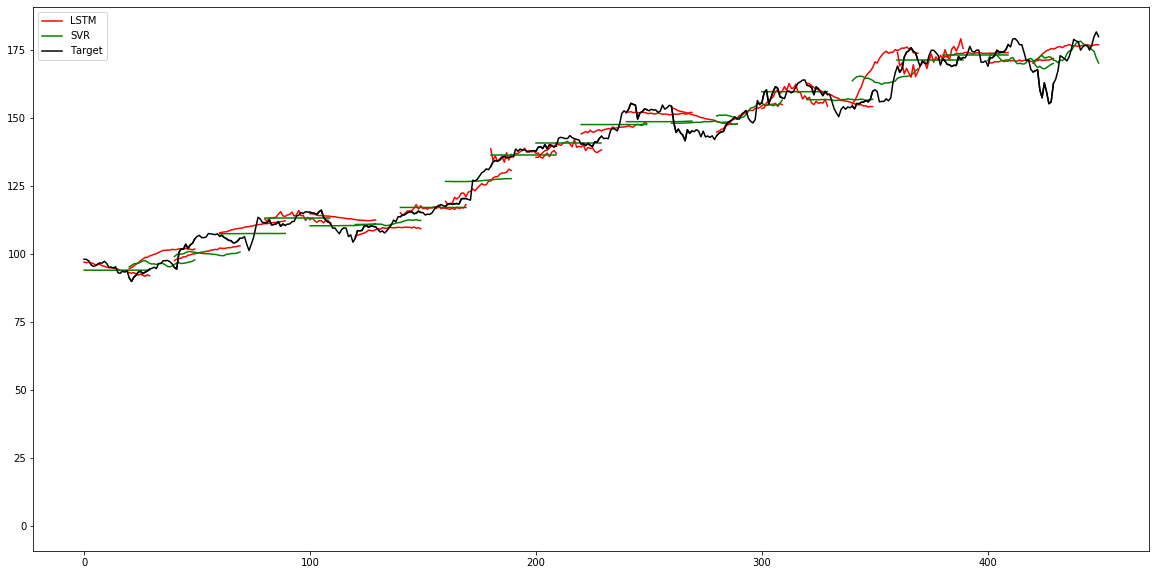

In [10]:
# Comparar contra SVR

plt.figure(figsize = (20,10))

results = []
for i in range(0,len(X_test)):
    scl = MinMaxScaler()
    scl.fit(X_test[i])
    scl.fit(y_test[i])
    d = scl.transform( X_test[i] )
    
    # LSTM
    y_pred = model.predict( d.reshape(1,d.shape[0],1) )
    y_pred = y_pred.reshape(-1,1)
    plt.plot([x + i*num_periods for x in range(len(y_pred))], scl.inverse_transform(y_pred.reshape(-1,1)), color='r')
    
    # SVR
    y_pred = []  
    for j in range(0,len(y_test[i])):
        #if j == 0:
            #y_pred.append(d[-1:][0])
        pred = svr.predict(d[-100:].reshape(1,100))
        d = np.concatenate([d,pred.reshape(1,1)])
        y_pred.append(pred)
    y_pred = np.array(y_pred).reshape(-1,1)
    y_pred = scl.inverse_transform(y_pred.reshape(-1,1))
    
    results.append(forecast_accuracy(y_pred, y_test[i]))
    plt.plot([x + i*num_periods for x in range(len(y_pred))], y_pred , color='g')
    
    # Actual values
    plt.plot([x + i*num_periods for x in range(len(y_test[i]))], y_test[i], color='k')
    
result_svr = pd.DataFrame(results)
result_svr.to_csv('svr_apple.csv')

plt.plot(0,0, color='r', label='LSTM') #only to place the label
plt.plot(0,0, color='g', label='SVR') #only to place the label
plt.plot(0,0, color='k', label='Target')
plt.legend(loc='best')
plt.show()

# Comparativa LSTM vs ARIMA

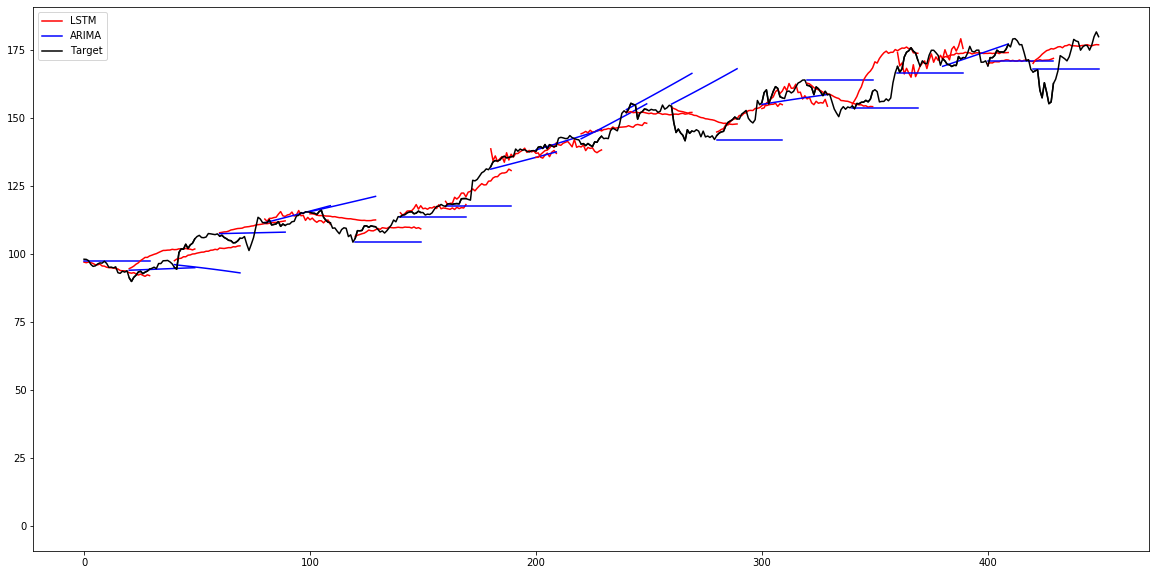

In [11]:
# Comparar contra ARIMA
plt.figure(figsize = (20,10))

results = []
for i in range(0,len(X_test)):
    scl = MinMaxScaler()
    scl.fit(X_test[i])
    scl.fit(y_test[i])
    d = scl.transform( X_test[i] )
    
    # LSTM
    y_pred = model.predict( d.reshape(1,d.shape[0],1) )
    y_pred = y_pred.reshape(-1,1)
    plt.plot([x + i*num_periods for x in range(len(y_pred))], scl.inverse_transform(y_pred.reshape(-1,1)), color='r')
    
    # ARIMA
    stepwise_fit = pm.auto_arima(np.log(X_test[i]), start_p=1, start_q=1, test='adf', max_p=10, max_q=5, m=7,
                             start_P=0, seasonal=False, d=None, D=0, trace=False,
                             error_action='ignore', suppress_warnings=True, stepwise=True)
    fc= stepwise_fit.predict(n_periods=len(y_test[i]), return_conf_int=False)
    y_pred = np.exp(fc)
    y_pred = y_pred.reshape(-1,1)
    
    results.append(forecast_accuracy(y_pred, y_test[i]))
    plt.plot([x + i*num_periods for x in range(len(y_pred))], y_pred, color='b')
    
    # Actual values
    plt.plot([x + i*num_periods for x in range(len(y_test[i]))], y_test[i], color='k')

plt.plot(0,0, color='r', label='LSTM') #only to place the label
plt.plot(0,0, color='b', label='ARIMA') #only to place the label
plt.plot(0,0, color='k', label='Target')
plt.legend(loc='best')
plt.show()

In [12]:
result_arima = pd.DataFrame(results)
result_arima.to_csv('arima_apple.csv')

# Solo ARIMA

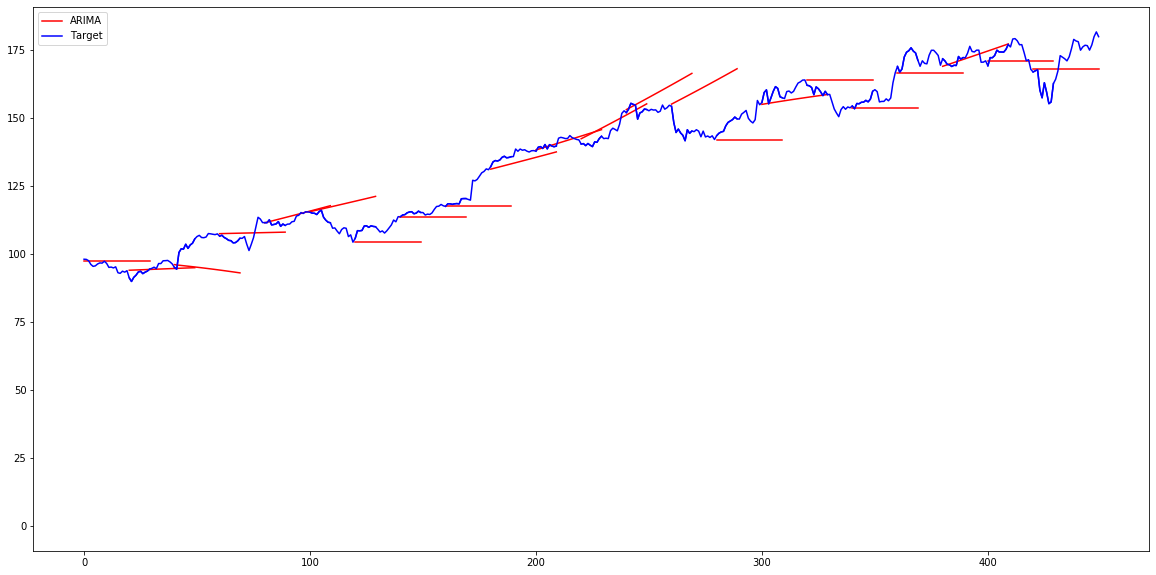

In [13]:
# Comparar contra ARIMA
plt.figure(figsize = (20,10))

results = []
for i in range(0,len(X_test)):
    # ARIMA
    stepwise_fit = pm.auto_arima(np.log(X_test[i]), start_p=1, start_q=1, test='adf', max_p=10, max_q=5, m=7,
                             start_P=0, seasonal=False, d=None, D=0, trace=False,
                             error_action='ignore', suppress_warnings=True, stepwise=True)
    fc= stepwise_fit.predict(n_periods=len(y_test[i]), return_conf_int=False)
    y_pred = np.exp(fc)
    y_pred = y_pred.reshape(-1,1)
    
    results.append(forecast_accuracy(y_pred, y_test[i]))
    plt.plot([x + i*num_periods for x in range(len(y_pred))], y_pred, color='r')
    
    # Actual values
    plt.plot([x + i*num_periods for x in range(len(y_test[i]))], y_test[i], color='b')

plt.plot(0,0, color='r', label='ARIMA')
plt.plot(0,0, color='b', label='Target')
plt.legend(loc='best')
plt.show()

result_arima = pd.DataFrame(results)
result_arima.to_csv('arima_apple.csv')